# Import

In [336]:
import os
from dotenv import load_dotenv
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy import stats

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import category_encoders as ce

import torch
from torch.utils.data import Dataset


load_dotenv()
sklearn.set_config(transform_output="pandas")

# Config

In [2]:
INPUT_DATA_PATH = os.getenv("INPUT_DATA_PATH")
OUTPUT_DATA_PATH = os.getenv("OUTPUT_DATA_PATH")

# Classes and functions

Функции для перевода временной метки в день недели и час

In [3]:
def hour_to_weekday(hour):
    day = hour // 24
    weekday = day % 7
    return weekday


def hour_to_daytime(hour):
    return hour % 24

Перевод строки в формате "1,2,3,4" в формат [1, 2, 3, 4]

In [ ]:
def str_to_list(X):
    for col in X.columns:
        X[col] = X[col].apply(lambda x: [int(v) for v in x.split(",")])
    
    return X

# Load data

In [323]:
user_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/users.tsv")
history_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/history.tsv")
validate_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate.tsv")

validate_answers_ds_path = os.path.join(INPUT_DATA_PATH, "Предсказание количества просмотров рекламы/validate_answers.tsv")

In [ ]:
user_ds = pd.read_csv(user_ds_path, sep="\t")
history_ds = pd.read_csv(history_ds_path, sep="\t")
validate_ds = pd.read_csv(validate_ds_path, sep="\t")

validate_answers_ds = pd.read_csv(validate_answers_ds_path, sep="\t")

Определяем pipeline для предобработки данных

In [ ]:
ct = make_column_transformer(
    (FunctionTransformer(str_to_list), ["publishers", "user_ids"]),

    remainder='passthrough',  # Остальные столбцы оставляем без изменений
    verbose_feature_names_out=False
)

# Explore data

## Step 1 - first connection

___
**users.tsv:**
- все пользователи уникальные,
- 30 пользователей без пола,
- 2180 пропущено возрастов, есть люди страше 90 лет,
- 84790 пропущено городов, из города с id=3 больше всего пользователей.

**history.tsv:**
- два выброса по cpm,
- активные часы - вечерние, активные дни - будни,
- есть периодичность и сезонность,
- все просмотры сконцентрированы на 4 площадках,
- два пользователя смотрят очень много объявлений (мб выбросы и стоит обрезать).

**validate.tsv:**
- в среднем рекламу размещают на ~5 дней, 75% квартиль покрывает 7 дней,
- максимум используется 6 площадок, в основном 3-4.

### user.tsv

Посмотрим на пропуски

In [ ]:
user_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27769 entries, 0 to 27768
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  27769 non-null  int64
 1   sex      27769 non-null  int64
 2   age      27769 non-null  int64
 3   city_id  27769 non-null  int64
dtypes: int64(4)
memory usage: 867.9 KB


In [ ]:
round((user_ds[["sex", "age", "city_id"]] == 0).sum()/len(user_ds), 3)

sex        0.001
age        0.079
city_id    0.305
dtype: float64

Посмотрим распределение по полу

<Axes: xlabel='sex'>

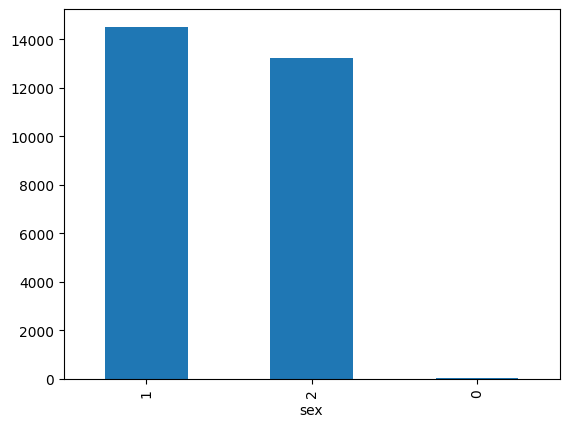

In [ ]:
user_ds["sex"].value_counts().plot(kind="bar")

Для признака age почти 8% данных пропущено. Посмотрим на распределения пользователей по возрасту

<Axes: >

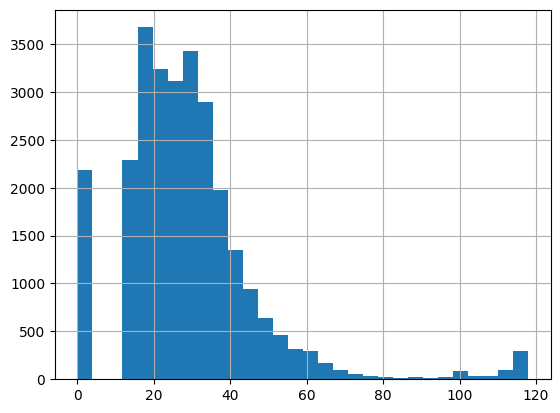

In [10]:
user_ds["age"].hist(bins=30)

По графику видно, что есть пользователи, которым больше 90 лет. Выведем сколько таких

In [17]:
print(f"Доля пользователей страше 90: {round((user_ds['age'] > 90).sum() / len(user_ds)*100, 2)}%")

Доля пользователей страше 90: 2.13%


Выведем средний возраст пользователей за исключением тех, кому больше 90 и не будем принимать во внимание пропуски (значение 0)

In [20]:
mask = (user_ds["age"] != 0) & (user_ds["age"] <= 90)
age_mean = np.mean(user_ds.loc[mask, "age"])
print(f"Средний возраст: {round(age_mean)}")

Средний возраст: 29


Чтобы заполнить пропуски применим KNNImputer. Для того, чтобы алгоритм лучше понимал, какое значение подойдет больше сгенерируем дополнительные признаки ([Feature engineering -> user.tsv](#feature-engineering)).

Создавать новые признаки будем на основе исторических данных. Поэтому перейдем к обзору history.tsv.

### history.tsv

In [7]:
history_ds.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


Для лучшего понимания данных добавим два признака ([Feature engineering -> history.tsv](#feature-engineering)):
- daytime - час просмотра рекламы,
- weekday - день просмотра рекламы.

In [24]:
history_ds.sample(5)

,hour,cpm,publisher,user_id,weekday,daytime
319525,494,58.86,1,7217,6,14
518921,770,30.00,1,8735,4,2
680078,1041,446.90,1,18060,1,9
1077519,1349,90.00,1,13441,0,5
294876,442,92.50,1,8444,4,10


Посмотрим в какой день недели и в какой день пользователи чаще всего видят рекламу

<Axes: >

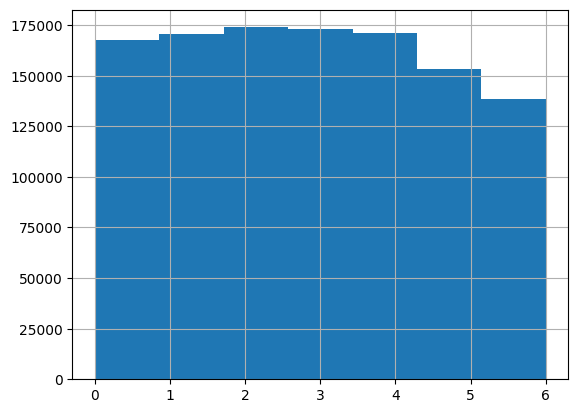

In [29]:
history_ds["weekday"].hist(bins=7)

<Axes: >

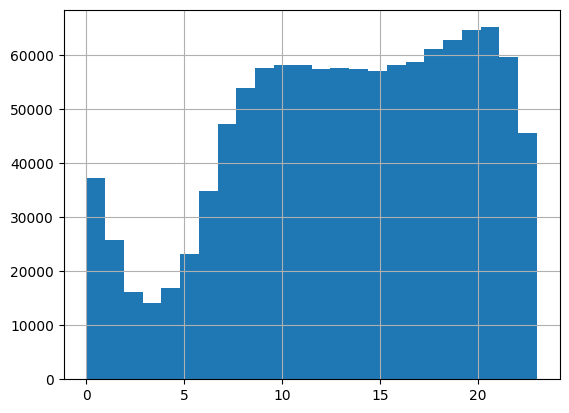

In [31]:
history_ds["daytime"].hist(bins=24)

Выведем популярность площадок

<Axes: >

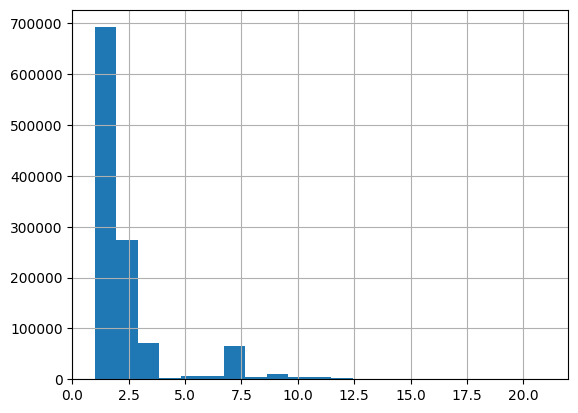

In [28]:
history_ds["publisher"].hist(bins=history_ds["publisher"].max())

Какой промежуток времени взят

In [34]:
print(f"Количество рассматриваемых дней: {round((np.max(history_ds['hour']) - np.min(history_ds['hour']))/24)}")

Количество рассматриваемых дней: 62


Временной ряд по неделям, дням и часам

<Axes: >

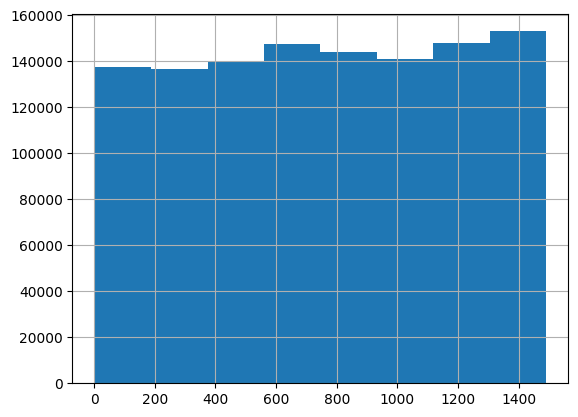

In [37]:
history_ds["hour"].hist(bins=62//7)

<Axes: >

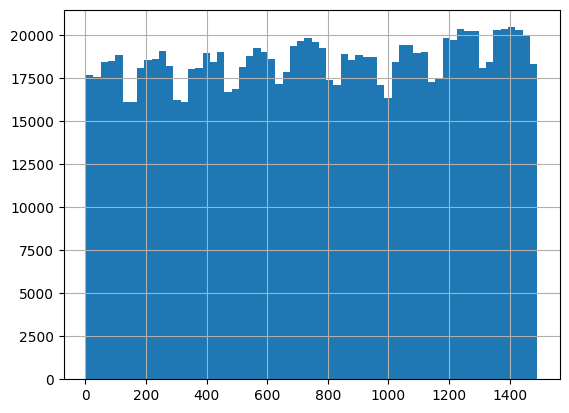

In [40]:
history_ds["hour"].hist(bins=62)

<Axes: >

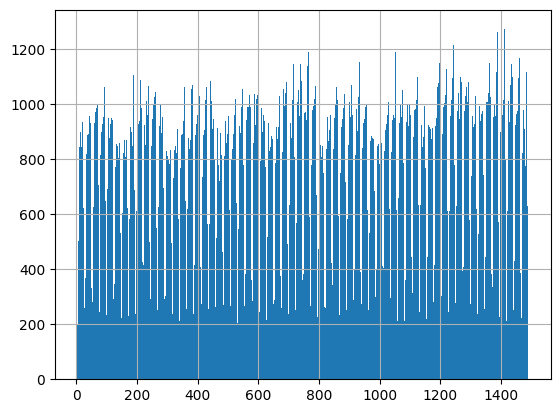

In [41]:
history_ds["hour"].hist(bins=62*24)

Распределение любимых площадок у пользователей

<BarContainer object of 19 artists>

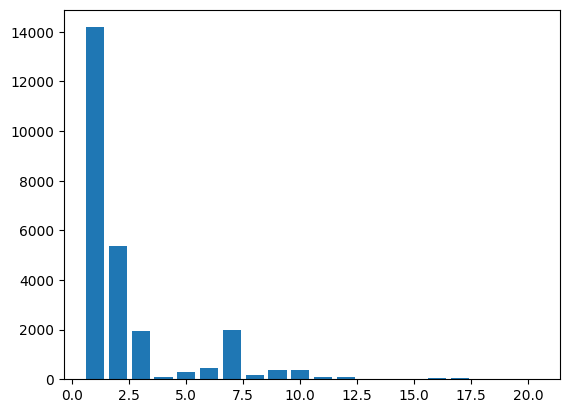

In [58]:
modes = []
for i, row in history_ds.groupby(by="user_id"):
    modes.append(row["publisher"].mode()[0])

v, c = np.unique(modes, return_counts=True)
plt.bar(v, c)

Распределение просмотров у пользователей в течении недели

In [102]:
num_week = 1
start_hour = (num_week - 1)*7*24
hour_end = num_week*7*24
mask = (history_ds["hour"] >= start_hour) & (history_ds["hour"] < hour_end)
week_data = history_ds.loc[mask, "user_id"]
v, c = np.unique(week_data, return_counts=True)
pd.Series(c).describe()

count    16237.000000
mean         7.500647
std          9.102951
min          1.000000
25%          2.000000
50%          4.000000
75%         10.000000
max        136.000000
dtype: float64

### validate.tsv

Посмотрим на данные

In [325]:
validate_ds.head()

,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."


In [300]:
validate_ds.dtypes

cpm              float64
hour_start         int64
hour_end           int64
publishers        object
audience_size      int64
user_ids          object
dtype: object

Для дальнейшего анализа переведем publishers и user_ids в списки ([Clean and prepare -> Step 1 -> validate.tsv](#clean-and-prepare-data))

In [445]:
validate_ds.head()

,publishers,user_ids,cpm,hour_start,hour_end,audience_size
0,"[7, 17]","[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",220.0,1058,1153,1906
1,"[3, 18]","[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",312.0,1295,1301,1380
2,"[1, 2, 3, 9, 15, 21]","[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",70.0,1229,1249,888
3,"[1, 14]","[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",240.0,1295,1377,440
4,"[1, 3, 7, 8]","[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",262.0,752,990,1476


Какой период размещения рекламы

In [296]:
round((validate_ds["hour_end"] - validate_ds["hour_start"]).describe(), 2)

count    1008.00
mean      101.18
std       126.40
min         2.00
25%         8.00
50%        36.50
75%       169.75
max       503.00
dtype: float64

Какое количество площадок фигурирует в объявлениях

<Axes: >

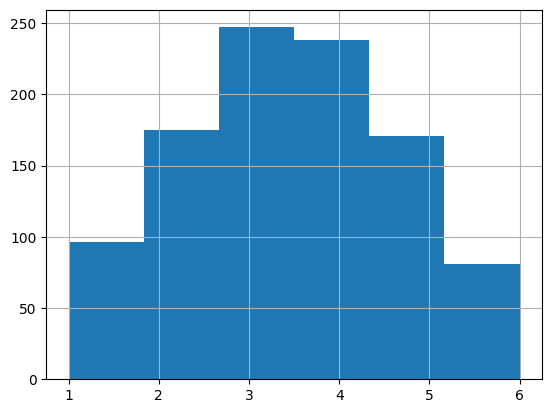

In [444]:
validate_ds["publishers"].apply(len).hist(bins=int(validate_ds["publishers"].apply(len).max()))

Статистика по audience_size

In [333]:
round(validate_ds["audience_size"].describe(), 2)

count    1008.00
mean     1090.09
std       613.56
min       300.00
25%       575.00
50%       960.00
75%      1464.00
max      2500.00
Name: audience_size, dtype: float64

Перейдем к формированию новых признаков ([Feature engineering -> validate.tsv](#feature-engineering))

## Step 2 - feature importance

___
После добавления новых признаков посмотрим какой вклад они приносят

### user.tsv

Посмотрим на корреляцию признаков между собой

In [154]:
ext_user_ds.corr().style.background_gradient(cmap='coolwarm')

,user_id,sex,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval,is_workday
user_id,1.000000,0.001652,0.012078,0.109968,-0.006642,-0.004627,-0.010060,-0.012467,-0.001371,0.004963
sex,0.001652,1.000000,-0.019877,0.014633,-0.032656,-0.009384,-0.017094,-0.014466,-0.027435,0.009308
age,0.012078,-0.019877,1.000000,0.047560,0.038372,-0.000947,-0.000271,0.000631,0.011663,0.000994
city_id,0.109968,0.014633,0.047560,1.000000,0.022402,-0.011935,-0.020698,-0.016715,-0.003714,0.006239
publishers,-0.006642,-0.032656,0.038372,0.022402,1.000000,0.210588,0.172331,0.146921,0.025186,-0.001053
views,-0.004627,-0.009384,-0.000947,-0.011935,0.210588,1.000000,0.830984,0.771151,0.036533,0.015773
views_per_week,-0.010060,-0.017094,-0.000271,-0.020698,0.172331,0.830984,1.000000,0.920311,0.038832,0.009457
views_per_day,-0.012467,-0.014466,0.000631,-0.016715,0.146921,0.771151,0.920311,1.000000,0.041943,-0.011914
top_time_interval,-0.001371,-0.027435,0.011663,-0.003714,0.025186,0.036533,0.038832,0.041943,1.000000,-0.038562
is_workday,0.004963,0.009308,0.000994,0.006239,-0.001053,0.015773,0.009457,-0.011914,-0.038562,1.000000


Посмотрим на статистики сильно коррелирующих признаков

In [158]:
ext_user_ds[["views_per_week", "views_per_day"]].describe()

,views_per_week,views_per_day
count,25536.000000,25536.000000
mean,0.945293,0.249138
std,1.724954,0.575356
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,29.000000,8.000000


<Axes: >

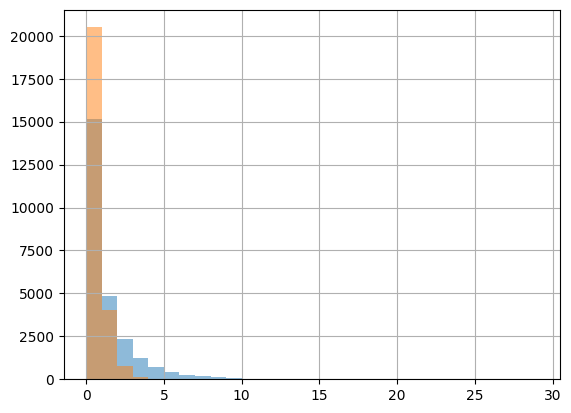

In [169]:
ext_user_ds["views_per_week"].hist(bins=int(ext_user_ds["views_per_week"].max()), alpha=0.5)
ext_user_ds["views_per_day"].hist(bins=int(ext_user_ds["views_per_day"].max()), alpha=0.5)

## Step 3 - after feature imputation

___
Смотрим на статистики признаков после заполнения пропусков в [Clean and prepare -> Step 2 -> user.tsv](#clean-and-prepare-data)

### user.tsv

Посмотрим остались ли пропуски

In [217]:
mask = (~ext_user_ds["user_id"].isin(sf_ext_user_ds["user_id"])) & (ext_user_ds["age"] == 0)
print(f"Количество пропущенных значений в age: {len(ext_user_ds.loc[mask])}")

Количество пропущенных значений в age: 193


In [218]:
ext_user_ds.loc[mask]

,user_id,sex,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval,is_workday
10,10,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
143,143,1,0,67,NaN,NaN,NaN,NaN,NaN,NaN
317,317,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
351,351,0,0,19,NaN,NaN,NaN,NaN,NaN,NaN
359,359,1,0,67,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
27428,27428,0,0,231,NaN,NaN,NaN,NaN,NaN,NaN
27544,27544,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
27668,27668,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
27748,27748,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Сколько данных с NaN

In [249]:
round(ext_user_ds.isna().sum()/len(ext_user_ds)*100, 1)

user_id              0.0
sex                  0.0
age                  0.0
city_id              0.0
publishers           8.0
views                8.0
views_per_week       8.0
views_per_day        8.0
top_time_interval    8.0
is_workday           8.0
dtype: float64

Сколько пользователей нет в истории

In [252]:
round((len(ext_user_ds)-len(history_ds["user_id"].unique()))/len(ext_user_ds)*100, 1)

8.0

Как мы видим пропуски остались, но мало. Удалим эти объекты, тк кроме age у этих же объектов отсутствуют значения и у других признаков ([Clean and prepare -> Step 2 -> user.tsv](#clean-and-prepare-data))

# Clean and prepare data

## Step 1 - first connection

___
**user.tsv**
- Заполняем признак sex средним значением и делаем его бинарным,

**history.tsv**
- ...

**validate.tsv**
- ...

**validate_answers.tsv**
- ...

### user.tsv

Заполняем пропуски единицей, приводим к бинарному виду для sex.

In [281]:
# Берем индексы со значением 0
zero_indices = user_ds[user_ds['sex'] == 0].index
half = len(zero_indices) // 2
# Заполняем 1 и 2
user_ds.loc[zero_indices[:half], 'sex'] = 1
user_ds.loc[zero_indices[half:], 'sex'] = 2
# Делаем признак бинарным
user_ds["sex"] = user_ds["sex"] - 1

user_ds.head()

,user_id,sex,age,city_id
0,0,1,19,0
1,1,0,0,1
2,2,1,24,2
3,3,0,20,3
4,4,1,29,4


Для людей старше 90 лет присвоим среднее значение

In [282]:
mask = (user_ds["age"] != 0) & (user_ds["age"] < 90)
age_mean = round(np.mean(user_ds.loc[mask, "age"]))

mask = user_ds["age"] >= 90
user_ds.loc[mask, "age"] = age_mean
user_ds["age"].describe()

count    27769.000000
mean        27.137888
std         13.912057
min          0.000000
25%         18.000000
50%         27.000000
75%         35.000000
max         89.000000
Name: age, dtype: float64

Для того, чтобы заполнить пропуски в age нужно выполнить следующие шаги:
1) Добавить новые признаки пользователям,
2) Масштабировать признаки,
3) Посчитать для каждого пропуска ближайшее значение с помощью KNNImputer.

Перейдем к генерации признаков ([Feature engineering -> user.tsv](#feature-engineering))

### validate.tsv

Переводим строки в списки

In [443]:
validate_ds = ct.fit_transform(validate_ds)
validate_ds.head()

,publishers,user_ids,cpm,hour_start,hour_end,audience_size
0,"[7, 17]","[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",220.0,1058,1153,1906
1,"[3, 18]","[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",312.0,1295,1301,1380
2,"[1, 2, 3, 9, 15, 21]","[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",70.0,1229,1249,888
3,"[1, 14]","[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",240.0,1295,1377,440
4,"[1, 3, 7, 8]","[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",262.0,752,990,1476


## Step 2 - after feature engineering

___
После генерации новых признаков чистим данные.

**user.tsv**
- с помощью KNN добавляем пропущенные значения в age,
- удаляем объекты, которые имеют много пропусков в признаках.

### user.tsv

Уберем данные с пропущенными признаками

In [ ]:
filtered_features = ext_user_ds[~ext_user_ds["views"].isna()]
filtered_features.head()

,user_id,sex,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval,is_workday
0,0,1,19,0,1.0,2.0,0.0,0.0,-0.866025,1.0
1,1,0,0,1,1.0,82.0,2.0,0.0,-0.707107,0.0
3,3,0,20,3,2.0,8.0,0.0,0.0,0.707107,1.0
4,4,1,29,4,2.0,132.0,3.0,1.0,-0.707107,1.0
5,5,1,22,5,1.0,9.0,0.0,0.0,-1.000000,1.0


Масштабируем данные

In [288]:
scaler = MinMaxScaler()
scaled_f_features = scaler.fit_transform(filtered_features.drop(columns=["user_id", "sex", "is_workday"]))
scaled_f_features.head()

,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval
0,0.213483,0.000000,0.0,0.000816,0.000000,0.000,0.066987
1,0.000000,0.000407,0.0,0.066122,0.068966,0.000,0.146447
3,0.224719,0.001221,0.2,0.005714,0.000000,0.000,0.853553
4,0.325843,0.001629,0.2,0.106939,0.103448,0.125,0.146447
5,0.247191,0.002036,0.0,0.006531,0.000000,0.000,0.000000


In [289]:
sf_ext_user_ds = filtered_features.copy()
sf_ext_user_ds[scaled_f_features.columns] = scaled_f_features
sf_ext_user_ds.head()

,user_id,sex,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval,is_workday
0,0,1,0.213483,0.000000,0.0,0.000816,0.000000,0.000,0.066987,1.0
1,1,0,0.000000,0.000407,0.0,0.066122,0.068966,0.000,0.146447,0.0
3,3,0,0.224719,0.001221,0.2,0.005714,0.000000,0.000,0.853553,1.0
4,4,1,0.325843,0.001629,0.2,0.106939,0.103448,0.125,0.146447,1.0
5,5,1,0.247191,0.002036,0.0,0.006531,0.000000,0.000,0.000000,1.0


Применим KNNImputer для присвоения значений пропускам в age

In [290]:
sf_ext_user_ds = sf_ext_user_ds.replace({"age": 0}, np.nan)

imputer = KNNImputer(n_neighbors=5, weights="uniform")
sf_ext_user_ds["age"] = imputer.fit_transform(sf_ext_user_ds.drop(columns=["user_id"]))["age"]
sf_ext_user_ds.head()

,user_id,sex,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval,is_workday
0,0,1,0.213483,0.000000,0.0,0.000816,0.000000,0.000,0.066987,1.0
1,1,0,0.397753,0.000407,0.0,0.066122,0.068966,0.000,0.146447,0.0
3,3,0,0.224719,0.001221,0.2,0.005714,0.000000,0.000,0.853553,1.0
4,4,1,0.325843,0.001629,0.2,0.106939,0.103448,0.125,0.146447,1.0
5,5,1,0.247191,0.002036,0.0,0.006531,0.000000,0.000,0.000000,1.0


Вернем масштаб данных и внесем данные в датасет user.tsv

In [291]:
inversed_feature = scaler.inverse_transform(sf_ext_user_ds[scaled_f_features.columns])
inversed_feature = pd.DataFrame(data=inversed_feature, columns=scaled_f_features.columns, index=sf_ext_user_ds.index)
inversed_feature.head()

,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval
0,19.0,0.0,1.0,2.0,0.0,0.0,-0.866025
1,35.4,1.0,1.0,82.0,2.0,0.0,-0.707107
3,20.0,3.0,2.0,8.0,0.0,0.0,0.707107
4,29.0,4.0,2.0,132.0,3.0,1.0,-0.707107
5,22.0,5.0,1.0,9.0,0.0,0.0,-1.000000


In [293]:
ext_user_ds.loc[inversed_feature.index, inversed_feature.columns] = inversed_feature
ext_user_ds.head()

/tmp/ipykernel_3064492/90890206.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[19.  35.4 20.  ... 21.  17.  30. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ext_user_ds.loc[inversed_feature.index, inversed_feature.columns] = inversed_feature
/tmp/ipykernel_3064492/90890206.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.000e+00 1.000e+00 3.000e+00 ... 1.953e+03 0.000e+00 0.000e+00]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ext_user_ds.loc[inversed_feature.index, inversed_feature.columns] = inversed_feature


,user_id,sex,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval,is_workday
0,0,1,19.0,0.0,1.0,2.0,0.0,0.0,-0.866025,1.0
1,1,0,35.4,1.0,1.0,82.0,2.0,0.0,-0.707107,0.0
2,2,1,24.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,20.0,3.0,2.0,8.0,0.0,0.0,0.707107,1.0
4,4,1,29.0,4.0,2.0,132.0,3.0,1.0,-0.707107,1.0


Посмотрим остались ли пропуски в age ([Explore data -> Step 3 -> user.tsv](#explore-data))

Удалим пустые объекты

In [294]:
mask = (ext_user_ds["age"] != 0) & (~ext_user_ds["views"].isna())
ext_user_ds = ext_user_ds.loc[mask]
ext_user_ds.head()

,user_id,sex,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval,is_workday
0,0,1,19.0,0.0,1.0,2.0,0.0,0.0,-0.866025,1.0
1,1,0,35.4,1.0,1.0,82.0,2.0,0.0,-0.707107,0.0
3,3,0,20.0,3.0,2.0,8.0,0.0,0.0,0.707107,1.0
4,4,1,29.0,4.0,2.0,132.0,3.0,1.0,-0.707107,1.0
5,5,1,22.0,5.0,1.0,9.0,0.0,0.0,-1.000000,1.0


In [295]:
len(ext_user_ds)

25536

Сохраним датасет

In [297]:
ext_user_ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "ext_user.csv"), index=False)

# Feature engineering

### user.tsv

___
Добавим новые признаки (делается после добавления признаков в history):
- publishers - кол-во используемых площадок,
- top_publisher - любимая площадка,
- views - кол-во просмотров за все время,
- views_per_week - среднее количество просмотров в неделю,
- views_per_day - среднее количество просмотров в день,
- top_time_interval - в какой промежуток времени видит рекламу чаще всего,
- is_workday - по будням или по выходным видит рекламу.

In [283]:
def get_interval_views(ds, step):
    interval_views = []
    start_hour = 0
    for end_hour in range(24, history_ds["hour"].max(), step):
        mask = (ds["hour"] >= start_hour) & (ds["hour"] < hour_end)
        interval_views.append(len(ds.loc[mask]))
        start_hour = end_hour

    return interval_views

In [286]:
new_features = {
    "user_id": [],
    "publishers": [],
    "views": [],
    "views_per_week": [],
    "views_per_day": [],
    "top_time_interval": [],
    "is_workday": []
}
users_history_ds = history_ds.groupby("user_id")
for user_id, user_history_ds in tqdm(users_history_ds, total=len(users_history_ds)):
    publishers = len(user_history_ds["publisher"].unique())
    views = len(user_history_ds)
    views_per_week = round(np.mean(get_interval_views(user_history_ds, step=24*7)))
    views_per_day = round(np.mean(get_interval_views(user_history_ds, step=24)))
    top_time_interval = np.cos(2*np.pi*user_history_ds["daytime"].mode()[0]/24)
    is_workday = 1 if user_history_ds["weekday"].mode()[0] <= 4 else 0

    new_features["user_id"].append(user_id)
    new_features["publishers"].append(publishers)
    new_features["views"].append(views)
    new_features["views_per_week"].append(views_per_week)
    new_features["views_per_day"].append(views_per_day)
    new_features["top_time_interval"].append(top_time_interval)
    new_features["is_workday"].append(is_workday)

ext_user_ds = user_ds.copy()
ext_user_ds = pd.merge(ext_user_ds, pd.DataFrame(new_features), how="left", on="user_id")
ext_user_ds.head()

100%|██████████| 25536/25536 [08:20<00:00, 51.02it/s]


,user_id,sex,age,city_id,publishers,views,views_per_week,views_per_day,top_time_interval,is_workday
0,0,1,19,0,1.0,2.0,0.0,0.0,-0.866025,1.0
1,1,0,0,1,1.0,82.0,2.0,0.0,-0.707107,0.0
2,2,1,24,2,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,20,3,2.0,8.0,0.0,0.0,0.707107,1.0
4,4,1,29,4,2.0,132.0,3.0,1.0,-0.707107,1.0


После того, как мы добавили новые признаки их стоит исследовать ([Explore data -> Step 2 -> user.tsv](#explore-data)).

Далее на основе новых признаков нужно заполнить пропущенные значения в столбце age, используя KNNImputer ([Clean and prepare -> Step 2 -> user.tsv](#clean-and-prepare-data)).

### history.tsv

___
Новые признаки для заполнения возраста:
- daytime - час просмотра рекламы,
- weekday - день просмотра рекламы.

In [7]:
history_ds.head()

,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148


In [285]:
history_ds["weekday"] = history_ds["hour"].apply(hour_to_weekday)
history_ds["daytime"] = history_ds["hour"].apply(hour_to_daytime)
history_ds.sample(5)

,hour,cpm,publisher,user_id,weekday,daytime
382420,586,30.00,2,6072,3,10
332318,525,90.00,1,11667,0,21
236418,369,387.42,1,9480,1,9
1016784,1342,35.06,1,15178,6,22
1097641,271,250.00,1,27099,4,7


Сохраним датасет

In [298]:
history_ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "ext_history.csv"), index=False)

### validate.tsv

___
Добавим новые признаки:
- среднее количество используемых в рекламе площадок среди пользователей за месяц в отношении к данным площадкам,
- пик активности у пользователей за неделю, месяц по времени, дню недели,
- среднее время сессии у пользователей за месяц, неделю,
- кол-во сессий у пользователей за месяц, неделю,
- средняя цена сессий за месяц, неделю,
- среднее кол-во просмотров у сессий за месяц, неделю.

In [27]:
ext_user_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_users.csv"))
ext_user_ds = ext_user_ds[["user_id", "sex", "age", "city_id"]]
ext_user_ds.head()

,user_id,sex,age,city_id
0,0,1,19,8479
1,1,0,30,16
2,2,1,24,1
3,3,0,20,1985
4,4,1,29,66


In [29]:
ext_history_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_history.csv"))
ext_history_ds.head()

,hour_old,cpm,publisher,user_id,weekday,hour
0,10,30.00,1,15661,0,10
1,8,41.26,1,8444,0,8
2,7,360.00,1,15821,0,7
3,18,370.00,1,21530,0,18
4,8,195.00,2,22148,0,8


In [70]:
ext_validate_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate.csv"))
ext_validate_ds["publishers"] = ext_validate_ds["publishers"].apply(ast.literal_eval)
ext_validate_ds["user_ids"] = ext_validate_ds["user_ids"].apply(ast.literal_eval)
ext_validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4


In [31]:
ext_validate_answers_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate_answers.csv"))
ext_validate_answers_ds.head()

,at_least_one,at_least_two,at_least_three
0,82,29,14
1,18,0,0
2,78,12,0
3,101,57,32
4,585,411,335


Добавим для каждого объекта из validate.tsv новые признаки.

1) Среднее количество используемых в рекламе площадок среди пользователей за месяц в отношении к данным площадкам:

In [77]:
new_data = {
    "used_publishers_ration": []
}
for i, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    publishers = row["publishers"]
    user_ids = row["user_ids"]
    start = row["hour_start_old"] - 31*24
    end = row["hour_start_old"]

    # Берем пользователей рекламы, площадки на которых размещаем и исторические данные за месяц
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["publisher"].isin(publishers)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_publishers = ext_history_ds.loc[mask, ["publisher", "user_id"]]
    # Для каждого пользователя считаем сколько подходящих групп он использовал и от этого берем среднее
    used_publishers_mean = np.mean(users_publishers.groupby("user_id")["publisher"].apply(lambda publishers: len(np.unique(publishers))))
    # Считаем отношение
    used_publishers_ration = used_publishers_mean/len(publishers)

    new_data["used_publishers_ration"].append(used_publishers_ration)

ext_validate_ds = ext_validate_ds.assign(**new_data)

100%|██████████| 1008/1008 [00:39<00:00, 25.28it/s]


In [91]:
ext_validate_ds["used_publishers_ration"].isna().sum()

np.int64(0)

In [81]:
ext_validate_ds.head()

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity,used_publishers_ration
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2,0.500000
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2,0.503846
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6,0.185101
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2,0.502347
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4,0.292857


2) Пик активности у пользователей за неделю, месяц по времени, дню недели:

In [87]:
new_data = {
    "top_time_month": [],
    "top_time_week": [],
    "top_weekday_month": [],
    "top_weekday_week": []
}
for i, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    user_ids = row["user_ids"]
    end = row["hour_start_old"]
    # Время-месяц
    start = row["hour_start_old"] - 31*24
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_hours = ext_history_ds.loc[mask, "hour"]
    users_weekdays = ext_history_ds.loc[mask, "weekday"]

    top_time_month = stats.mode(users_hours)[0]
    top_weekday_month = stats.mode(users_weekdays)[0]
    # Время-неделя
    start = row["hour_start_old"] - 7*24
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_hours = ext_history_ds.loc[mask, "hour"]
    users_weekdays = ext_history_ds.loc[mask, "weekday"]

    top_time_week = stats.mode(users_hours)[0]
    top_weekday_week = stats.mode(users_weekdays)[0]

    new_data["top_time_month"].append(top_time_month)
    new_data["top_time_week"].append(top_time_week)
    new_data["top_weekday_month"].append(top_weekday_month)
    new_data["top_weekday_week"].append(top_weekday_week)

ext_validate_ds = ext_validate_ds.assign(**new_data)

100%|██████████| 1008/1008 [00:29<00:00, 33.72it/s]


In [90]:
ext_validate_ds[["top_time_month", "top_time_week", "top_weekday_month", "top_weekday_week"]].isna().sum()

top_time_month       0
top_time_week        0
top_weekday_month    0
top_weekday_week     0
dtype: int64

In [ ]:
round(ext_validate_ds[["top_time_month", "top_time_week", "top_weekday_month", "top_weekday_week"]].describe(), 2)

,top_time_month,top_time_week,top_weekday_month,top_weekday_week
count,1008.00,1008.00,1008.00,1008.00
mean,19.04,18.28,2.26,2.18
std,3.47,3.82,1.63,1.51
min,0.00,0.00,0.00,0.00
25%,19.00,17.00,1.00,1.00
50%,20.00,20.00,2.00,2.00
75%,21.00,21.00,4.00,3.00
max,23.00,23.00,6.00,6.00


3) Среднее время сессии у пользователей за месяц, неделю
4) Кол-во сессий у пользователей за месяц, неделю
5) Средняя цена сессий за месяц, неделю
6) Среднее кол-во просмотров у сессий за месяц, неделю

In [137]:
new_data = {
    "session_duration_month_mean": [],
    "session_duration_week_mean": [],

    "session_quantity_month": [],
    "session_quantity_week": [],

    "session_cpm_month_mean": [],
    "session_cpm_week_mean": [],

    "views_month_mean": [],
    "views_week_mean": []
}
for _, row in tqdm(ext_validate_ds.iterrows(), total=len(ext_validate_ds)):
    user_ids = row["user_ids"]
    end = row["hour_start_old"]
    # Месяц
    start = row["hour_start_old"] - 31*24
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_hours = ext_history_ds.loc[mask, ["user_id", "hour_old", "cpm"]].sort_values("hour_old")
    # Группируем по пользователям и считаем сколько времени длилась сессия
    users_sessions = []
    users_cpms = []
    for _, h_row in users_hours.groupby("user_id"):
        hours = list(h_row["hour_old"])
        cpms = list(h_row["cpm"])

        user_sessions = [hours[0]]
        user_cpms = [cpms[0]]
        for i, hour in enumerate(hours[1:], 1):
            if hour - user_sessions[-1] <= 6:
                user_sessions.append(hour)
                user_cpms.append(cpms[i])
                continue

            users_sessions.append(user_sessions)
            users_cpms.append(user_cpms)
            user_sessions = [hour]
            user_cpms = [cpms[i]]
        
        users_sessions.append(user_sessions)
        users_cpms.append(user_cpms)

    session_duration_month_mean = round(np.mean([np.max(user_sessions) - np.min(user_sessions) + 1 for user_sessions in users_sessions]))
    session_quantity_month = len(users_sessions)
    session_cpm_month_mean = np.mean([np.mean(user_cpms) for user_cpms in users_cpms])
    views_month_mean = len(users_hours)
    # Неделя
    start = row["hour_start_old"] - 7*24
    mask = (ext_history_ds["user_id"].isin(user_ids)) & (ext_history_ds["hour_old"].between(start, end, "left"))
    users_hours = ext_history_ds.loc[mask, ["user_id", "hour_old", "cpm"]].sort_values("hour_old")
    # Группируем по пользователям и считаем сколько времени длилась сессия
    users_sessions = []
    users_cpms = []
    for _, h_row in users_hours.groupby("user_id"):
        hours = list(h_row["hour_old"])
        cpms = list(h_row["cpm"])

        user_sessions = [hours[0]]
        user_cpms = [cpms[0]]
        for i, hour in enumerate(hours[1:], 1):
            if hour - user_sessions[-1] <= 6:
                user_sessions.append(hour)
                user_cpms.append(cpms[i])
                continue

            users_sessions.append(user_sessions)
            users_cpms.append(user_cpms)
            user_sessions = [hour]
            user_cpms = [cpms[i]]
        
        users_sessions.append(user_sessions)
        users_cpms.append(user_cpms)

    session_duration_week_mean = round(np.mean([np.max(user_sessions) - np.min(user_sessions) + 1 for user_sessions in users_sessions]))
    session_quantity_week = len(users_sessions)
    session_cpm_week_mean = np.mean([np.mean(user_cpms) for user_cpms in users_cpms])
    views_week_mean = len(users_hours)

    new_data["session_duration_month_mean"].append(session_duration_month_mean)
    new_data["session_duration_week_mean"].append(session_duration_week_mean)

    new_data["session_quantity_month"].append(session_quantity_month)
    new_data["session_quantity_week"].append(session_quantity_week)

    new_data["session_cpm_month_mean"].append(session_cpm_month_mean)
    new_data["session_cpm_week_mean"].append(session_cpm_week_mean)

    new_data["views_month_mean"].append(views_month_mean)
    new_data["views_week_mean"].append(views_week_mean)

ext_validate_ds = ext_validate_ds.assign(**new_data)

100%|██████████| 1008/1008 [05:06<00:00,  3.29it/s]


In [146]:
round(ext_validate_ds[['session_duration_month_mean', 'session_duration_week_mean',
       'session_quantity_month', 'session_quantity_week',
       'session_cpm_month_mean', 'session_cpm_week_mean', 'views_month_mean',
       'views_week_mean']].describe(), 2)

,session_duration_month_mean,session_duration_week_mean,session_quantity_month,session_quantity_week,session_cpm_month_mean,session_cpm_week_mean,views_month_mean,views_week_mean
count,1008.00,1008.00,1008.00,1008.00,1008.00,1008.00,1008.00,1008.00
mean,2.15,2.14,10912.88,2510.06,242.14,251.63,24276.27,5601.70
std,0.57,0.56,10173.41,2355.25,153.55,164.27,28332.79,6563.43
min,1.00,1.00,129.00,28.00,58.50,54.61,133.00,29.00
25%,2.00,2.00,4356.75,993.75,185.73,188.39,8864.00,2023.50
50%,2.00,2.00,8726.00,2008.00,210.27,216.24,17867.00,4099.00
75%,2.00,2.00,14222.50,3249.75,232.61,249.64,30527.50,7013.00
max,4.00,4.00,81393.00,19038.00,1102.84,1301.24,251260.00,58649.00


In [147]:
ext_validate_ds.columns

Index(['cpm', 'hour_start_old', 'hour_end', 'publishers', 'audience_size',
       'user_ids', 'weekday_start', 'duration', 'hour_start',
       'publisher_quantity', 'used_publishers_ration', 'top_time_month',
       'top_time_week', 'top_weekday_month', 'top_weekday_week',
       'session_duration_month_mean', 'session_duration_week_mean',
       'session_quantity_month', 'session_quantity_week',
       'session_cpm_month_mean', 'session_cpm_week_mean', 'views_month_mean',
       'views_week_mean'],
      dtype='object')

In [148]:
ext_validate_ds.to_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate_2.csv"), index=False)

In [6]:
ext_validate_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate_2.csv"))
ext_validate_ds["publishers"] = ext_validate_ds["publishers"].apply(ast.literal_eval)
ext_validate_ds["user_ids"] = ext_validate_ds["user_ids"].apply(ast.literal_eval)

In [8]:
ext_validate_answers_ds = pd.read_csv(os.path.join(OUTPUT_DATA_PATH, "ext_validate_answers.csv"))

In [7]:
ext_validate_ds

,cpm,hour_start_old,hour_end,publishers,audience_size,user_ids,weekday_start,duration,hour_start,publisher_quantity,...,top_weekday_month,top_weekday_week,session_duration_month_mean,session_duration_week_mean,session_quantity_month,session_quantity_week,session_cpm_month_mean,session_cpm_week_mean,views_month_mean,views_week_mean
0,220.0,1058,1153,"[7, 17]",1906,"[12, 44, 46, 50, 58, 71, 93, 122, 134, 143, 17...",2,95,2,2,...,0,0,2,2,18372,4114,210.480455,221.471304,38082,8588
1,312.0,1295,1301,"[3, 18]",1380,"[29, 81, 98, 102, 165, 167, 195, 205, 218, 231...",4,6,4,2,...,2,1,3,3,35777,8321,188.068698,199.748844,91285,21335
2,70.0,1229,1249,"[1, 2, 3, 9, 15, 21]",888,"[12, 23, 25, 29, 45, 85, 92, 124, 156, 190, 27...",2,20,2,6,...,1,1,2,2,9049,2055,231.275441,224.800802,19524,4514
3,240.0,1295,1377,"[1, 14]",440,"[44, 122, 187, 209, 242, 255, 312, 345, 382, 4...",4,82,4,2,...,2,4,2,2,4140,932,212.932135,225.402752,8483,1904
4,262.0,752,990,"[1, 3, 7, 8]",1476,"[15, 24, 30, 43, 50, 53, 96, 105, 159, 168, 18...",3,238,3,4,...,2,2,2,2,12393,2881,252.865318,265.688009,25310,5906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,127.0,1095,1154,"[2, 7, 12, 15, 16]",368,"[38, 50, 143, 237, 456, 649, 653, 698, 881, 89...",3,59,3,5,...,1,0,2,2,3320,744,202.874765,188.274907,6614,1492
1004,90.0,1052,1056,"[2, 21]",484,"[1, 4, 61, 212, 230, 348, 356, 372, 429, 431, ...",1,4,1,2,...,0,2,2,2,4818,1094,204.525761,198.658989,10286,2338
1005,122.0,1058,1063,"[2, 5]",704,"[1, 23, 29, 104, 136, 176, 201, 206, 250, 269,...",2,5,2,2,...,1,2,3,3,16735,3787,179.105573,184.306063,40183,8801
1006,138.0,932,1169,"[1, 2, 7]",1210,"[67, 73, 80, 146, 182, 202, 212, 254, 307, 377...",3,237,3,3,...,2,0,2,2,10260,2432,211.501190,213.593645,20662,4976


In [9]:
ext_validate_answers_ds.head()

,at_least_one,at_least_two,at_least_three
0,82,29,14
1,18,0,0
2,78,12,0
3,101,57,32
4,585,411,335


In [ ]:
pd.concat([ext_validate_ds, ext_validate_answers_ds], axis=1).to_csv(os.path.join(OUTPUT_DATA_PATH, "dataset.csv"), index=False)